## Постановка задачи
Медицинская организация хочет автоматизировать оценку стоимости лечения пациента на основе его характеристик и параметров госпитализации. Для этого опубликован набор данных, который включает более 10 000 строк и 15 столбцов.

**Названия столбцов с пояснением:**
- **Name:** Имя пациента, к которому относится медицинская запись.
- **Age:** Возраст пациента на момент госпитализации (в годах).
- **Gender:** Пол пациента (Male — мужчина, Female — женщина).
- **Blood Type:** Группа крови пациента (например, A+, O−, B+, AB−).
- **Medical Condition:** Основной диагноз/медицинское состояние (например, Diabetes, Hypertension, Asthma).
- **Date of Admission:** Дата поступления пациента в медицинское учреждение.
- **Doctor:** Имя лечащего врача, ответственного за пациента.
- **Hospital:** Название больницы/клиники, где проходила госпитализация.
- **Insurance Provider:** Страховая компания пациента (Aetna, Blue Cross, Cigna, UnitedHealthcare, Medicare и др.).
- **Billing Amount:** Сумма, выставленная к оплате за лечение. **ТАРГЕТ**
- **Room Number:** Номер палаты, в которой размещён пациент.
- **Admission Type:** Тип госпитализации (Emergency — экстренная, Elective — плановая, Urgent — срочная).
- **Discharge Date:** Дата выписки пациента из медицинского учреждения.
- **Medication:** Назначенный пациенту препарат (Aspirin, Ibuprofen, Penicillin, Paracetamol, Lipitor и др.).
- **Test Results:** Результат медицинского теста (Normal — норма, Abnormal — отклонение, Inconclusive — неоднозначный). 

## Импорт основных библиотек

In [2]:
# Необходимо для корректной работы внешних .py файлов
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import seaborn as sns
from helper import *
from plots import *
import random

In [4]:
# фиксируем состояние генератора псевдослучайных чисел. Это необходимо, чтобы результаты модели не менялись с каждым новым запуском 
SEED = 42 # можно указать любое число
np.random.seed(SEED)
random.seed(SEED)

##  1. Изучение структуры данных

In [5]:
# Загружаем датасет в память
df = pd.read_csv("data.csv")
df.head(5)

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [5]:
# Смотрим на детали
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 6.4

в данном датасете отсутствуют пропущенные значения

In [6]:
# Смотрим на статистики по числовым переменным (категориальные сюда не входят)
df.describe()

,Age,Billing Amount,Room Number
count,55500.000000,55500.000000,55500.000000
mean,51.539459,25539.316097,301.134829
std,19.602454,14211.454431,115.243069
min,13.000000,-2008.492140,101.000000
25%,35.000000,13241.224652,202.000000
50%,52.000000,25538.069376,302.000000
75%,68.000000,37820.508436,401.000000
max,89.000000,52764.276736,500.000000


## 2. Проверка на корректность и качество данных

### 2.1 Проверка на дубликаты

In [7]:
# Подсчет числа дублированных строк
df.duplicated().sum() 

np.int64(534)

534 дубликата

### 2.2 Пропущенные значения

In [9]:
# выводим число пропущенных значений по каждому столбцу
df.isnull().sum()

Name                  0
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Date of Admission     0
Doctor                0
Hospital              0
Insurance Provider    0
Billing Amount        0
Room Number           0
Admission Type        0
Discharge Date        0
Medication            0
Test Results          0
dtype: int64

### 2.3 Корректность по столбцам

In [10]:
# Убедимся, что только 2 значения Gender
df['Gender'].value_counts()

Gender
Male      27774
Female    27726
Name: count, dtype: int64

In [13]:
# Убедимся, нет отрицательных значений Billing Amount 
len(df[df['Billing Amount'] < 0])

108

108 отрицательных значений. В будующем их стоит выбросить

In [14]:
# Убедимся, нет отрицательных значений Age 
len(df[df['Age'] < 0])

0

In [15]:
# Убедимся, нет отрицательных значений Room Number 
len(df[df['Room Number'] < 0])

0

In [18]:
# убедимся, что даты в правильном формате
pd.to_datetime(df['Date of Admission'])
pd.to_datetime(df['Discharge Date'])

0       2024-02-02
1       2019-08-26
2       2022-10-07
3       2020-12-18
4       2022-10-09
           ...    
55495   2020-09-15
55496   2020-02-01
55497   2020-08-10
55498   2019-05-31
55499   2024-04-29
Name: Discharge Date, Length: 55500, dtype: datetime64[ns]

In [17]:
# Убедимся, что в Blood Type только валидные группы ('A+', 'A-', 'B+', 'B-', 'AB+', 'AB-', 'O+', 'O-')
df['Blood Type'].value_counts()

Blood Type
A-     6969
A+     6956
AB+    6947
AB-    6945
B+     6945
B-     6944
O+     6917
O-     6877
Name: count, dtype: int64

In [19]:
# Убедимся, что только 3 значения Admission Type
df['Admission Type'].value_counts()

Admission Type
Elective     18655
Urgent       18576
Emergency    18269
Name: count, dtype: int64

In [20]:
# Убедимся, что только 3 значения Test Results
df['Test Results'].value_counts()

Test Results
Abnormal        18627
Normal          18517
Inconclusive    18356
Name: count, dtype: int64

In [ ]:
df['Hospital'].value_counts()

Hospital
LLC Smith                     44
Ltd Smith                     39
Johnson PLC                   38
Smith Ltd                     37
Smith PLC                     36
                              ..
Hammond Ltd                    1
Moran Smith and Galloway,      1
Winters Martin, and Neal       1
James-Owen                     1
Marks, and Vazquez Jenkins     1
Name: count, Length: 39876, dtype: int64

In [6]:
df['Hospital'].nunique()

39876

In [8]:
df['Insurance Provider'].value_counts()

Insurance Provider
Cigna               11249
Medicare            11154
UnitedHealthcare    11125
Blue Cross          11059
Aetna               10913
Name: count, dtype: int64

In [10]:
df['Admission Type'].value_counts()

Admission Type
Elective     18655
Urgent       18576
Emergency    18269
Name: count, dtype: int64

In [12]:
df['Medication'].value_counts()

Medication
Lipitor        11140
Ibuprofen      11127
Aspirin        11094
Paracetamol    11071
Penicillin     11068
Name: count, dtype: int64

In [ ]:
df['Test Results'].value_counts()

Test Results
Abnormal        18627
Normal          18517
Inconclusive    18356
Name: count, dtype: int64

In [55]:
df['Medical Condition'].value_counts()

Medical Condition
Arthritis       9308
Diabetes        9304
Hypertension    9245
Obesity         9231
Cancer          9227
Asthma          9185
Name: count, dtype: int64

## 3. Детальное изучение признаков (и таргета)

### 3.1 Числовые переменные

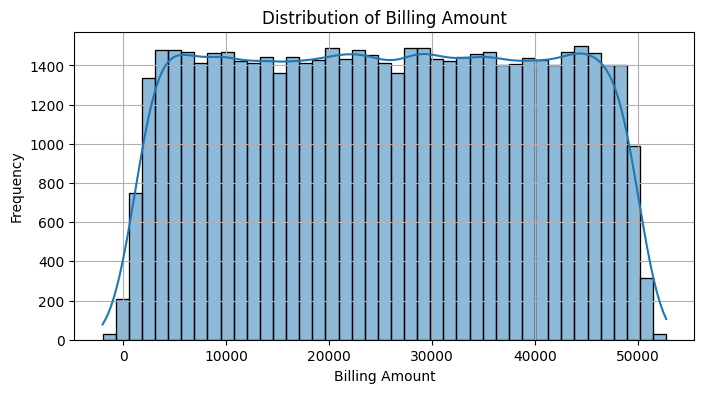

In [22]:
# Строим гистограмму распределения Billing Amount
plot_hist_numeric(df, 'Billing Amount')

Видим, что значения Billing Amount довольно равномерно распределены в диапазоне примерно от 0 до 50 000.Небольшое снижение частот наблюдается только на самых низких и самых высоких значениях, их можно рассматривать как редкие крайние наблюдения, но явных аномальных хвостов здесь нет.

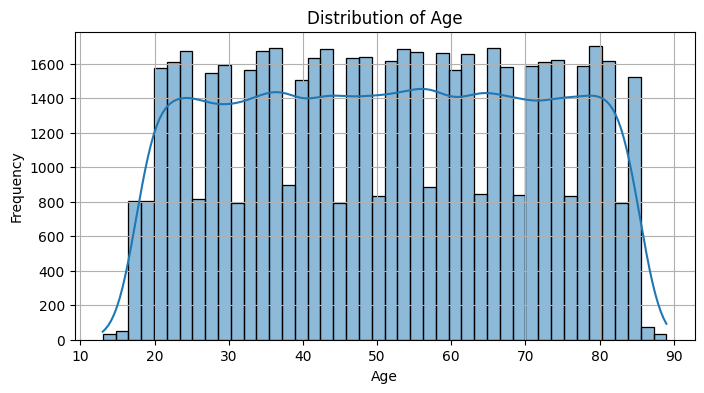

In [23]:
# Строим гистограмму распределения CoapplicantIncome
plot_hist_numeric(df, 'Age')

Видим, что возраст распределён примерно равномерно в диапазоне 20–80 лет

### 3.2 Категориальные переменные

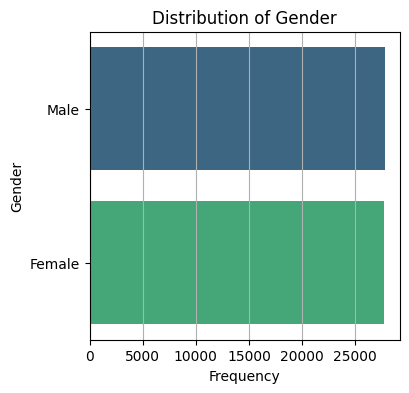

In [24]:
# Строим гистограмму распределения Gender
plot_hist_categorical(df, 'Gender')

Большинство клиентов - мужчины

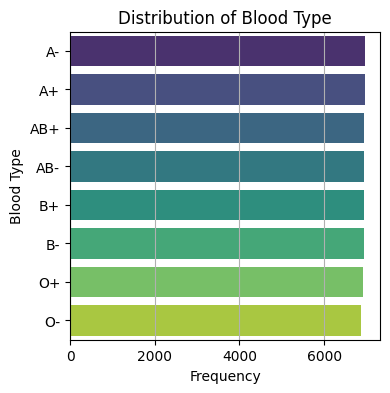

In [25]:
# Строим гистограмму распределения Blood Type
plot_hist_categorical(df, 'Blood Type')

группа крови распределена равномерно

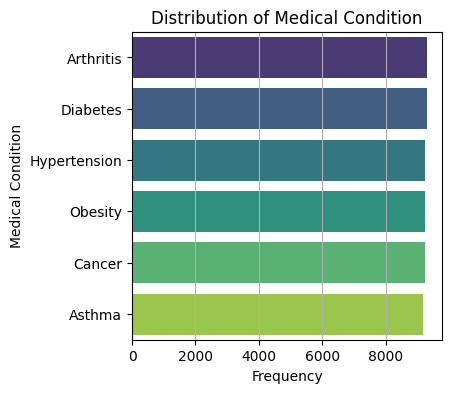

In [27]:
# Строим гистограмму распределения Medical Condition
plot_hist_categorical(df, 'Medical Condition')

Диагноз распределен равномерно

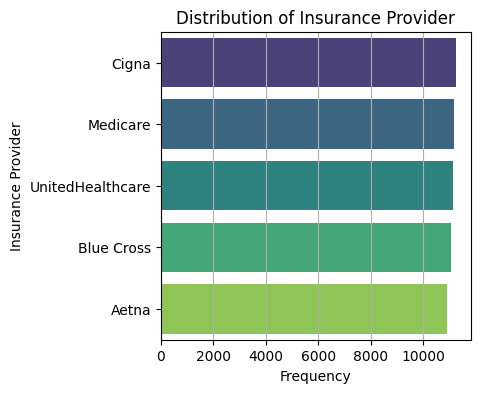

In [9]:
# Строим гистограмму распределения Insurance Provider
plot_hist_categorical(df, 'Insurance Provider')

Варианты стаховых компаний довольно сбалансированны

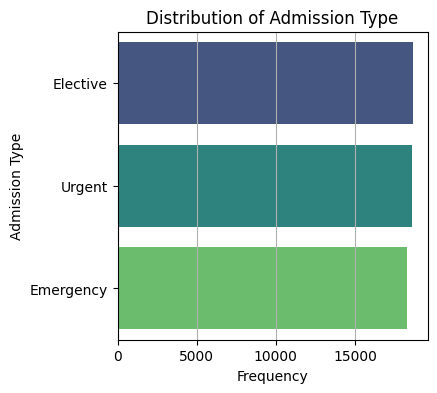

In [11]:
# Строим гистограмму распределения Admission Type
plot_hist_categorical(df, 'Admission Type')

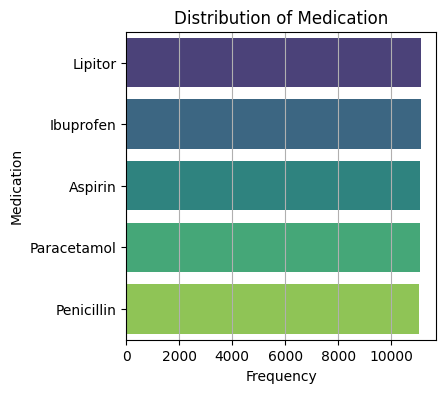

In [13]:
# Строим гистограмму распределения Medication
plot_hist_categorical(df, 'Medication')

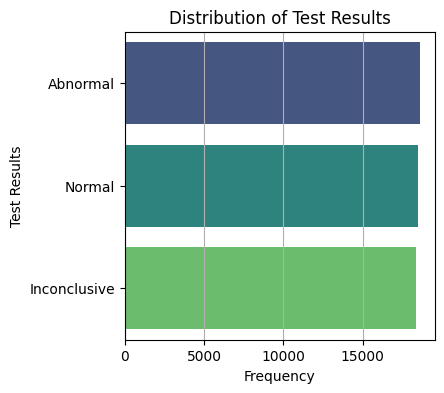

In [15]:
# Строим гистограмму распределения Test Results
plot_hist_categorical(df, 'Test Results')

## 4. Изучение взаимосвязей между признаками

### 4.1 Общая матрица корреляций

Наша цель состоит в том, чтобы понять, какие столбцы коррелируют друг с другом наиболее сильно и далее изучить подробнее эти корреляции. также понять, какие из столбцов сильнее всего коррелируют с таргетом

In [6]:
# удаляем Hospital (тк он имеет 39876 уникальных значений, что очень много), номер комнаты, имя и доктора, тк они не несут какого-то значения
df = df.drop(columns=['Hospital', 'Room Number', "Name", "Doctor"])

interval columns not set, guessing: ['Age', 'Billing Amount']


c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable Date of Admission is large: 1827. Are you sure this is not an interval variable? Analysis for pairs of variables including Date of Admission can be slow.
  warnings.warn(
c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable Discharge Date is large: 1856. Are you sure this is not an interval variable? Analysis for pairs of variables including Discharge Date can be slow.
  warnings.warn(


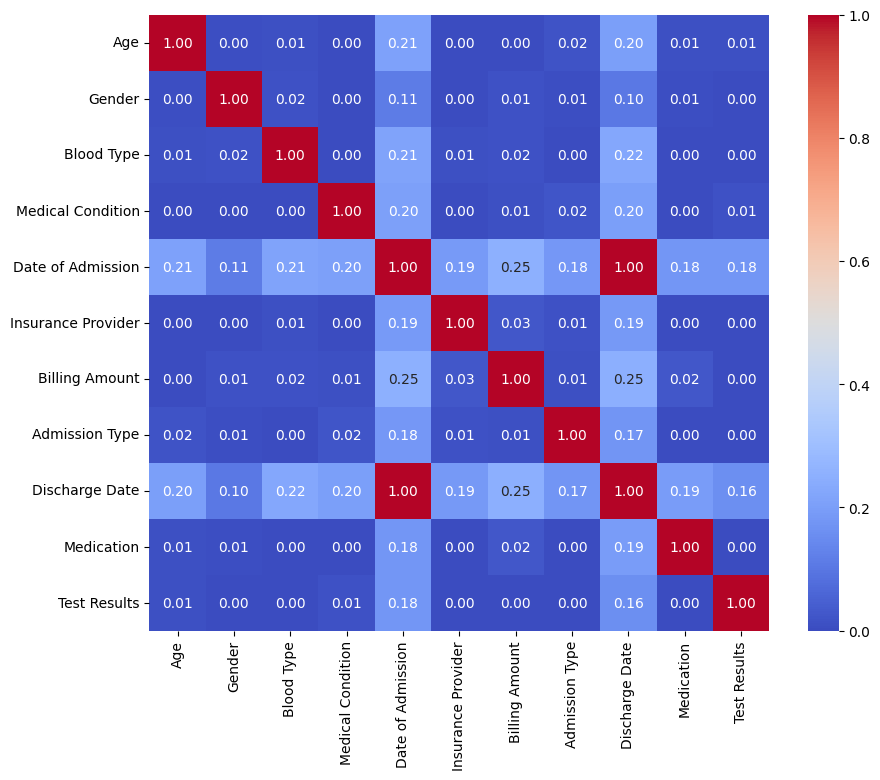

In [35]:
# поскольку в нашем датасете присутствуют категориальные признаки, используем корреляцию phik, которая способна с ними работать
plot_phik(df)

Между большинством признаков корреляции очень слабые (0.0–0.03) — мультиколлинеарности нет. Чуть выше связи у Date of Admission и Discharge Date с другими полями (0.18–0.22), что логично, тк даты связаны с типом госпитализации, диагнозом и т.п.

## 5. Препроцессинг данных

### 5.1 Общие преобразования

In [7]:
df_preprocessed = df.copy()

In [8]:
df_preprocessed.head()

,Age,Gender,Blood Type,Medical Condition,Date of Admission,Insurance Provider,Billing Amount,Admission Type,Discharge Date,Medication,Test Results
0,30,Male,B-,Cancer,2024-01-31,Blue Cross,18856.281306,Urgent,2024-02-02,Paracetamol,Normal
1,62,Male,A+,Obesity,2019-08-20,Medicare,33643.327287,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,76,Female,A-,Obesity,2022-09-22,Aetna,27955.096079,Emergency,2022-10-07,Aspirin,Normal
3,28,Female,O+,Diabetes,2020-11-18,Medicare,37909.782410,Elective,2020-12-18,Ibuprofen,Abnormal
4,43,Female,AB+,Cancer,2022-09-19,Aetna,14238.317814,Urgent,2022-10-09,Penicillin,Abnormal


In [9]:
# Удаляем полные дубликаты строк
df_preprocessed = df_preprocessed.drop_duplicates()

In [10]:
# Удаляем строки с отрицательными значениями таргета Billing Amount
df_preprocessed = df_preprocessed[df_preprocessed['Billing Amount'] >= 0]

In [11]:
# Преобразуем возраст в числовой тип
df_preprocessed['Age'] = pd.to_numeric(df_preprocessed['Age'])

In [12]:
# Преобразуем даты в тип datetime
df_preprocessed['Date of Admission'] = pd.to_datetime(
    df_preprocessed['Date of Admission'], errors='coerce'
)
df_preprocessed['Discharge Date'] = pd.to_datetime(
    df_preprocessed['Discharge Date'], errors='coerce'
)

In [13]:
# Проверим, что не осталось битых дат
df_preprocessed[['Date of Admission', 'Discharge Date']].isna().sum()

Date of Admission    0
Discharge Date       0
dtype: int64

In [14]:
# Делаем числовые признаки из даты
df_preprocessed["Admission_Year"]      = df_preprocessed["Date of Admission"].dt.year
df_preprocessed["Admission_Month"]     = df_preprocessed["Date of Admission"].dt.month
df_preprocessed["Admission_DayOfWeek"] = df_preprocessed["Date of Admission"].dt.dayofweek  # 0=Пн

df_preprocessed["Discharge_Year"]      = df_preprocessed["Discharge Date"].dt.year
df_preprocessed["Discharge_Month"]     = df_preprocessed["Discharge Date"].dt.month
df_preprocessed["Discharge_DayOfWeek"] = df_preprocessed["Discharge Date"].dt.dayofweek  # 0=Пн

In [15]:
# Исходную дату выбрасываем
df_preprocessed = df_preprocessed.drop(columns=["Date of Admission"])
df_preprocessed = df_preprocessed.drop(columns=["Discharge Date"])

In [16]:
cols_drop = ['Name', 'Doctor', ]

In [17]:
# Убеждаемся, что типы признаков сохранились как нам нужно
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54860 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  54860 non-null  int64  
 1   Gender               54860 non-null  object 
 2   Blood Type           54860 non-null  object 
 3   Medical Condition    54860 non-null  object 
 4   Insurance Provider   54860 non-null  object 
 5   Billing Amount       54860 non-null  float64
 6   Admission Type       54860 non-null  object 
 7   Medication           54860 non-null  object 
 8   Test Results         54860 non-null  object 
 9   Admission_Year       54860 non-null  int32  
 10  Admission_Month      54860 non-null  int32  
 11  Admission_DayOfWeek  54860 non-null  int32  
 12  Discharge_Year       54860 non-null  int32  
 13  Discharge_Month      54860 non-null  int32  
 14  Discharge_DayOfWeek  54860 non-null  int32  
dtypes: float64(1), int32(6), int64(1), object

### 5.2 Разбиение датасета 

In [18]:
# делим данные на признаки и таргет
X, y = divide_data(df_preprocessed, 'Billing Amount')

In [19]:
# Разбиваем данные на train и test с соотношением 80 на 20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=SEED, 
)

In [20]:
X_train

,Age,Gender,Blood Type,Medical Condition,Insurance Provider,Admission Type,Medication,Test Results,Admission_Year,Admission_Month,Admission_DayOfWeek,Discharge_Year,Discharge_Month,Discharge_DayOfWeek
45840,21,Female,B-,Hypertension,UnitedHealthcare,Urgent,Lipitor,Normal,2021,12,4,2022,1,6
31106,82,Male,B-,Asthma,Blue Cross,Emergency,Paracetamol,Inconclusive,2021,11,6,2021,12,6
48304,45,Male,O-,Asthma,Medicare,Elective,Ibuprofen,Normal,2022,10,3,2022,10,1
40732,26,Female,B-,Diabetes,Medicare,Elective,Aspirin,Inconclusive,2019,6,6,2019,6,6
54306,70,Female,AB+,Hypertension,Aetna,Emergency,Lipitor,Inconclusive,2021,10,0,2021,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44814,31,Male,AB+,Obesity,Aetna,Elective,Aspirin,Normal,2022,5,3,2022,5,0
54920,53,Male,B+,Obesity,UnitedHealthcare,Emergency,Lipitor,Normal,2020,7,4,2020,8,5
38219,39,Male,B-,Cancer,Cigna,Elective,Aspirin,Abnormal,2022,9,6,2022,9,0
862,84,Female,O-,Arthritis,Aetna,Elective,Paracetamol,Normal,2020,7,2,2020,7,3


In [21]:
X_train_preprocessed = X_train.copy()

In [22]:
categorical_cols = ['Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Admission Type', 'Medication', 'Test Results']
numeric_cols = ['Age']

### 5.1 Обработка пропущенных значений

In [23]:
# Убеждаемся, что типы данных не поменялись
X_train_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43888 entries, 45840 to 15819
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  43888 non-null  int64 
 1   Gender               43888 non-null  object
 2   Blood Type           43888 non-null  object
 3   Medical Condition    43888 non-null  object
 4   Insurance Provider   43888 non-null  object
 5   Admission Type       43888 non-null  object
 6   Medication           43888 non-null  object
 7   Test Results         43888 non-null  object
 8   Admission_Year       43888 non-null  int32 
 9   Admission_Month      43888 non-null  int32 
 10  Admission_DayOfWeek  43888 non-null  int32 
 11  Discharge_Year       43888 non-null  int32 
 12  Discharge_Month      43888 non-null  int32 
 13  Discharge_DayOfWeek  43888 non-null  int32 
dtypes: int32(6), int64(1), object(7)
memory usage: 4.0+ MB


In [24]:
# убедимся, что пропусков больше нет
X_train_preprocessed.isnull().sum()

Age                    0
Gender                 0
Blood Type             0
Medical Condition      0
Insurance Provider     0
Admission Type         0
Medication             0
Test Results           0
Admission_Year         0
Admission_Month        0
Admission_DayOfWeek    0
Discharge_Year         0
Discharge_Month        0
Discharge_DayOfWeek    0
dtype: int64

### 5.2 Кодирование категориальных переменных

In [25]:
# Будем использовать порядковое кодирование. Для этого выпишем все категории для каждого столбца в порядке увеличения номера
category_orders = [
    ['Male', 'Female'], # gender
    ['A+', 'A-', 'B+', 'B-', 'AB+', 'AB-', 'O+', 'O-'], # Blood Type                         
    ['Arthritis', 'Diabetes', 'Hypertension', 'Obesity', 'Cancer', 'Asthma'], # Medical Condition    
    ['UnitedHealthcare', 'Cigna', 'Medicare', 'Blue Cross', 'Aetna'], # Insurance Provider        
    ['Urgent', 'Emergency', 'Elective'], # Admission Type
    ['Lipitor', 'Ibuprofen', 'Aspirin', 'Paracetamol', 'Penicillin'], # Medication
    ['Abnormal', 'Normal', 'Inconclusive'], # Test Results
]

encoder = OrdinalEncoder(categories=category_orders)
X_train_preprocessed[categorical_cols] = encoder.fit_transform(X_train_preprocessed[categorical_cols])

In [26]:
# посмотрим на результат работы кодировщика
X_train_preprocessed

,Age,Gender,Blood Type,Medical Condition,Insurance Provider,Admission Type,Medication,Test Results,Admission_Year,Admission_Month,Admission_DayOfWeek,Discharge_Year,Discharge_Month,Discharge_DayOfWeek
45840,21,1.0,3.0,2.0,0.0,0.0,0.0,1.0,2021,12,4,2022,1,6
31106,82,0.0,3.0,5.0,3.0,1.0,3.0,2.0,2021,11,6,2021,12,6
48304,45,0.0,7.0,5.0,2.0,2.0,1.0,1.0,2022,10,3,2022,10,1
40732,26,1.0,3.0,1.0,2.0,2.0,2.0,2.0,2019,6,6,2019,6,6
54306,70,1.0,4.0,2.0,4.0,1.0,0.0,2.0,2021,10,0,2021,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44814,31,0.0,4.0,3.0,4.0,2.0,2.0,1.0,2022,5,3,2022,5,0
54920,53,0.0,2.0,3.0,0.0,1.0,0.0,1.0,2020,7,4,2020,8,5
38219,39,0.0,3.0,4.0,1.0,2.0,2.0,0.0,2022,9,6,2022,9,0
862,84,1.0,7.0,0.0,4.0,2.0,3.0,1.0,2020,7,2,2020,7,3


### 5.3 Итоговый пайплайн для препроцессинга
Для удобства объединим все наши преобразования в единый пайплайн, который можно будет впоследствии переиспользовать на тестовой выборке. Это поможет избежать излишнего копипаста, ошибок и предотваратить data leakage

In [27]:
# Создаем предобработчик данных в виде последовательного Pipeline
preprocessor = Pipeline([   
    # Кодирование категориальных признаков (зависит от завершения обоих этапов импутации)
    ('transformations', ColumnTransformer(
        transformers=[
            ('encoder',
             OrdinalEncoder(categories=category_orders),
             categorical_cols)
        ],
        remainder='passthrough',  # числовые колонки передаются без изменений
        verbose_feature_names_out=False
    ))
])

# Устанавливаем вывод в формате pandas DataFrame (для sklearn версии 1.0 и выше)
preprocessor.set_output(transform="pandas")

,steps,"[('transformations', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [28]:
# обучаем и применяем наш пайплайн к тестовой выборке
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, index=X_train.index)

In [29]:
# смотрим на результат работы пайплайна
X_train_preprocessed 

,Gender,Blood Type,Medical Condition,Insurance Provider,Admission Type,Medication,Test Results,Age,Admission_Year,Admission_Month,Admission_DayOfWeek,Discharge_Year,Discharge_Month,Discharge_DayOfWeek
45840,1.0,3.0,2.0,0.0,0.0,0.0,1.0,21,2021,12,4,2022,1,6
31106,0.0,3.0,5.0,3.0,1.0,3.0,2.0,82,2021,11,6,2021,12,6
48304,0.0,7.0,5.0,2.0,2.0,1.0,1.0,45,2022,10,3,2022,10,1
40732,1.0,3.0,1.0,2.0,2.0,2.0,2.0,26,2019,6,6,2019,6,6
54306,1.0,4.0,2.0,4.0,1.0,0.0,2.0,70,2021,10,0,2021,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44814,0.0,4.0,3.0,4.0,2.0,2.0,1.0,31,2022,5,3,2022,5,0
54920,0.0,2.0,3.0,0.0,1.0,0.0,1.0,53,2020,7,4,2020,8,5
38219,0.0,3.0,4.0,1.0,2.0,2.0,0.0,39,2022,9,6,2022,9,0
862,1.0,7.0,0.0,4.0,2.0,3.0,1.0,84,2020,7,2,2020,7,3


In [30]:
# снова проверим типы данных. Мы видим, что все столбцы теперь числовые, что нам и требовалось
X_train_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43888 entries, 45840 to 15819
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               43888 non-null  float64
 1   Blood Type           43888 non-null  float64
 2   Medical Condition    43888 non-null  float64
 3   Insurance Provider   43888 non-null  float64
 4   Admission Type       43888 non-null  float64
 5   Medication           43888 non-null  float64
 6   Test Results         43888 non-null  float64
 7   Age                  43888 non-null  int64  
 8   Admission_Year       43888 non-null  int32  
 9   Admission_Month      43888 non-null  int32  
 10  Admission_DayOfWeek  43888 non-null  int32  
 11  Discharge_Year       43888 non-null  int32  
 12  Discharge_Month      43888 non-null  int32  
 13  Discharge_DayOfWeek  43888 non-null  int32  
dtypes: float64(7), int32(6), int64(1)
memory usage: 4.0 MB


## 6. Построение базовой модели (baseline)
Сейчас наша задача построить базовую модель, от которой мы будем отталкиваться в дальнейшем для применения улучшений. Здесь мы намеренно не трогаем большую часть гиперпараметров моделей и оставляем значения по умолчанию. Подбор этих параметров будет осуществляться позже на финальных стадиях. Мы также не совершали преобразований с данными, направленных на улучшение, поскольку пока что нам не с чем сравнивать наш результат. 

In [31]:
# применяем уже обученный пайплайн к тестовой выборке. 
# Очень важно: здесь уже вызываем transform без fit, чтобы не допустить обучения на тестовых данных
X_test_preprocessed = preprocessor.transform(X_test)

In [32]:
X_test_preprocessed

,Gender,Blood Type,Medical Condition,Insurance Provider,Admission Type,Medication,Test Results,Age,Admission_Year,Admission_Month,Admission_DayOfWeek,Discharge_Year,Discharge_Month,Discharge_DayOfWeek
53540,0.0,2.0,1.0,1.0,0.0,0.0,1.0,66,2020,4,3,2020,4,6
19040,0.0,3.0,2.0,3.0,2.0,4.0,0.0,64,2021,11,0,2021,12,2
26733,0.0,4.0,4.0,1.0,2.0,4.0,0.0,41,2021,6,3,2021,7,4
51885,1.0,5.0,0.0,4.0,0.0,4.0,1.0,73,2024,1,3,2024,2,3
14974,0.0,0.0,2.0,4.0,1.0,3.0,0.0,37,2022,9,6,2022,9,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43570,0.0,4.0,4.0,0.0,1.0,4.0,2.0,62,2023,1,5,2023,1,4
47667,1.0,1.0,1.0,0.0,1.0,2.0,2.0,54,2021,9,0,2021,9,6
34598,0.0,2.0,4.0,0.0,1.0,0.0,1.0,45,2022,11,6,2022,11,0
8390,1.0,0.0,5.0,1.0,2.0,3.0,1.0,57,2024,4,6,2024,4,2


In [33]:
X_test_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10972 entries, 53540 to 45114
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               10972 non-null  float64
 1   Blood Type           10972 non-null  float64
 2   Medical Condition    10972 non-null  float64
 3   Insurance Provider   10972 non-null  float64
 4   Admission Type       10972 non-null  float64
 5   Medication           10972 non-null  float64
 6   Test Results         10972 non-null  float64
 7   Age                  10972 non-null  int64  
 8   Admission_Year       10972 non-null  int32  
 9   Admission_Month      10972 non-null  int32  
 10  Admission_DayOfWeek  10972 non-null  int32  
 11  Discharge_Year       10972 non-null  int32  
 12  Discharge_Month      10972 non-null  int32  
 13  Discharge_DayOfWeek  10972 non-null  int32  
dtypes: float64(7), int32(6), int64(1)
memory usage: 1.0 MB


In [34]:
X_test_preprocessed.isnull().sum()

Gender                 0
Blood Type             0
Medical Condition      0
Insurance Provider     0
Admission Type         0
Medication             0
Test Results           0
Age                    0
Admission_Year         0
Admission_Month        0
Admission_DayOfWeek    0
Discharge_Year         0
Discharge_Month        0
Discharge_DayOfWeek    0
dtype: int64

In [35]:
feature_names = X_test_preprocessed.columns.to_list()

### 6.1 Dummy Classifier
Для начала попробуем использовать глупый классификатор, который всегда предсказывает только самый частый класс и посмотреть на значение метрик. Это даст нам понимание, от какого нижнего порога метрик нам отталкиваться и с чем сравнивать наши модели.

c:\Users\theea\Desktop\Healthcare\plots.py:470: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette="viridis")


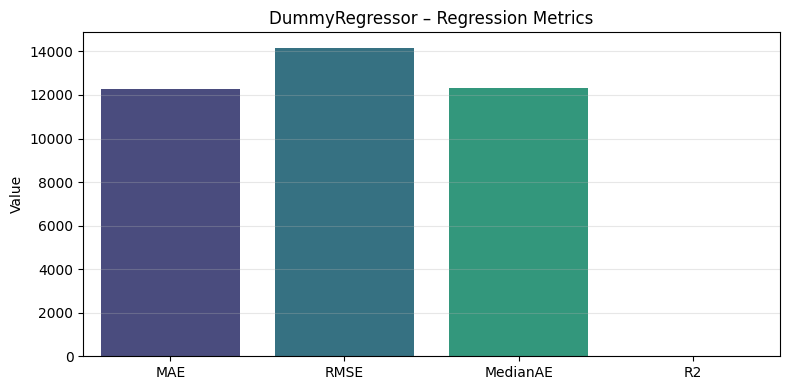


            DUMMYREGRESSOR REGRESSION EVALUATION            
  Metric      Value
     MAE 12266.5394
    RMSE 14167.9337
MedianAE 12304.1512
      R2    -0.0000



In [36]:
# Задаем и обучаем модель
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X_train_preprocessed, y_train)

# Получаем предсказания
y_pred = dummy_reg.predict(X_test_preprocessed) 

# Считаем метрики для модели и выводим графики
dummy_reg_metrics = evaluate_regression(
    y_true=y_test,
    y_pred=y_pred,
    model_name="DummyRegressor"
)

По метрикам видно, что MAE = 12 к, RMSE = 14 к, MedianAE = 12 к — то есть регрессор в среднем промахивается по счёту на 12–14 тысяч.

### 6.2 Логистическая регрессия

<string>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



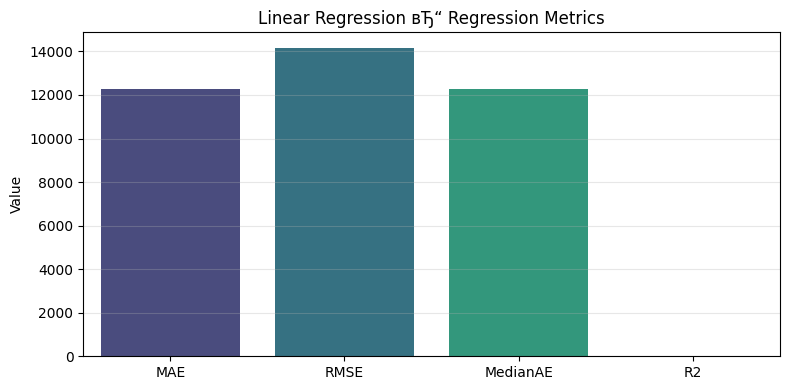


          LINEAR REGRESSION REGRESSION EVALUATION           
  Metric      Value
     MAE 12266.1425
    RMSE 14167.9438
MedianAE 12292.2258
      R2    -0.0000



In [240]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_preprocessed, y_train)

y_pred = lin_reg.predict(X_test_preprocessed) 

lin_reg_metrics = evaluate_regression(
    y_true=y_test,
    y_pred=y_pred,
    model_name="Linear Regression"
)

c:\Users\theea\Desktop\Healthcare\plots.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  category_counts = category_counts.sort_values(ascending=False)


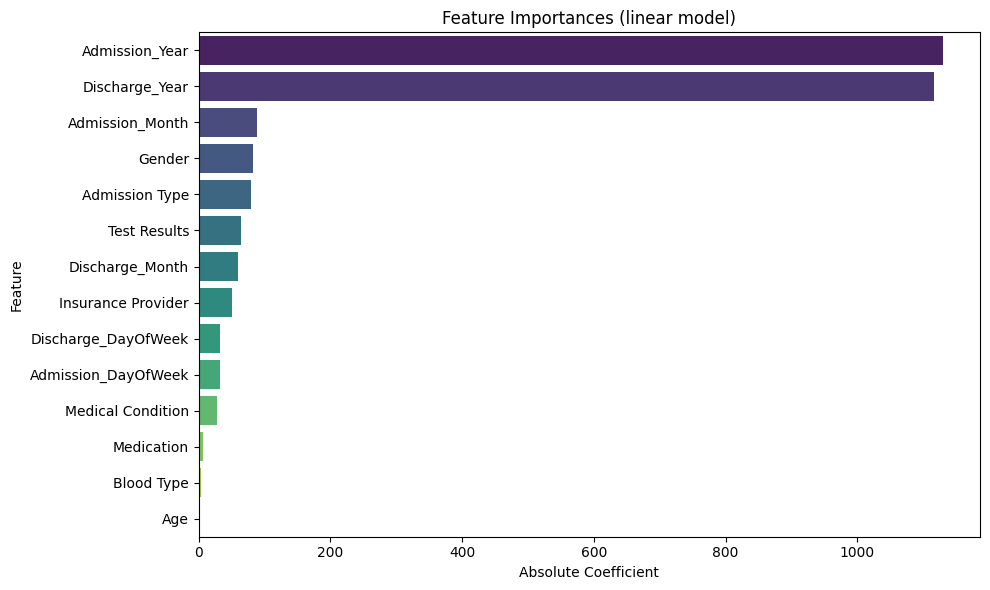

,Feature,Importance
8,Admission_Year,1129.973640
11,Discharge_Year,1116.678211
9,Admission_Month,87.760269
0,Gender,82.713643
4,Admission Type,79.333967
6,Test Results,63.628536
12,Discharge_Month,59.654576
3,Insurance Provider,49.731282
13,Discharge_DayOfWeek,32.349261
10,Admission_DayOfWeek,32.032732


In [241]:
# Построим гистограмму важностей для каждой фичи
plot_feature_importance(lin_reg, feature_names)

модель сильнее всего опирается на пол, тип госпитализации, страховку и день недели поступления. 
Слабее всего влияют Blood Type и Age (коэффициенты почти нули). Эти признаки точно не нулевые по влиянию. Для нормальной интерпретации стоило бы использовать OneHotEncoder + линейную модель

### 6.3 Дерево решений

<string>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



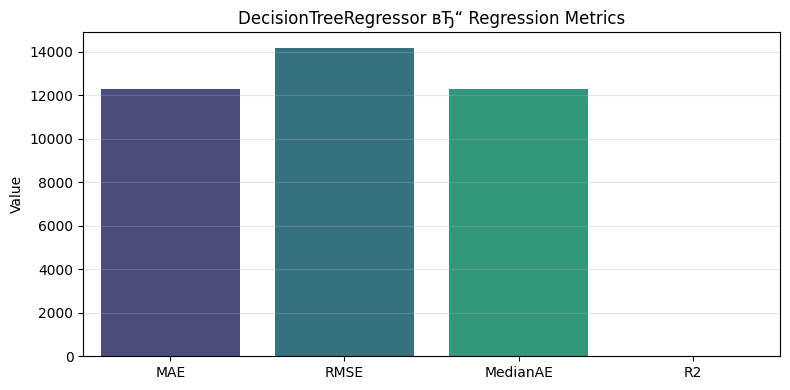


        DECISIONTREEREGRESSOR REGRESSION EVALUATION         
  Metric      Value
     MAE 12272.1359
    RMSE 14183.5540
MedianAE 12275.2731
      R2    -0.0022



In [242]:
decision_tree = DecisionTreeRegressor(random_state=SEED, max_depth=4)
decision_tree.fit(X_train_preprocessed, y_train)

y_pred = decision_tree.predict(X_test_preprocessed)

decision_tree_metrics = evaluate_regression(
    y_true=y_test,
    y_pred=y_pred,
    model_name="DecisionTreeRegressor"
)

c:\Users\theea\Desktop\Healthcare\plots.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  category_counts = category_counts.sort_values(ascending=False)


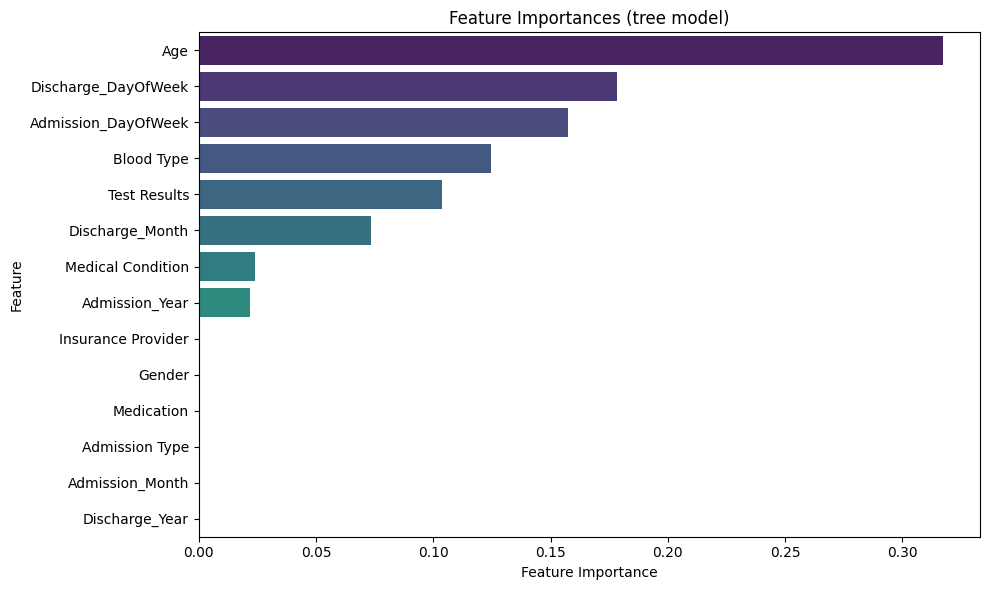

,Feature,Importance
7,Age,0.317202
13,Discharge_DayOfWeek,0.178119
10,Admission_DayOfWeek,0.157409
1,Blood Type,0.124449
6,Test Results,0.103493
12,Discharge_Month,0.073508
2,Medical Condition,0.024168
8,Admission_Year,0.021653
3,Insurance Provider,0.000000
0,Gender,0.000000


In [243]:
plot_feature_importance(decision_tree, feature_names)

Дерево сильнее всего опирается на возраст пациента и календарные признаки (день недели и месяц госпитализации). Медицинские характеристики (диагноз, группа крови) оказывают заметно меньший вклад, а пол, тип госпитализации и страховая компания практически не используются моделью.

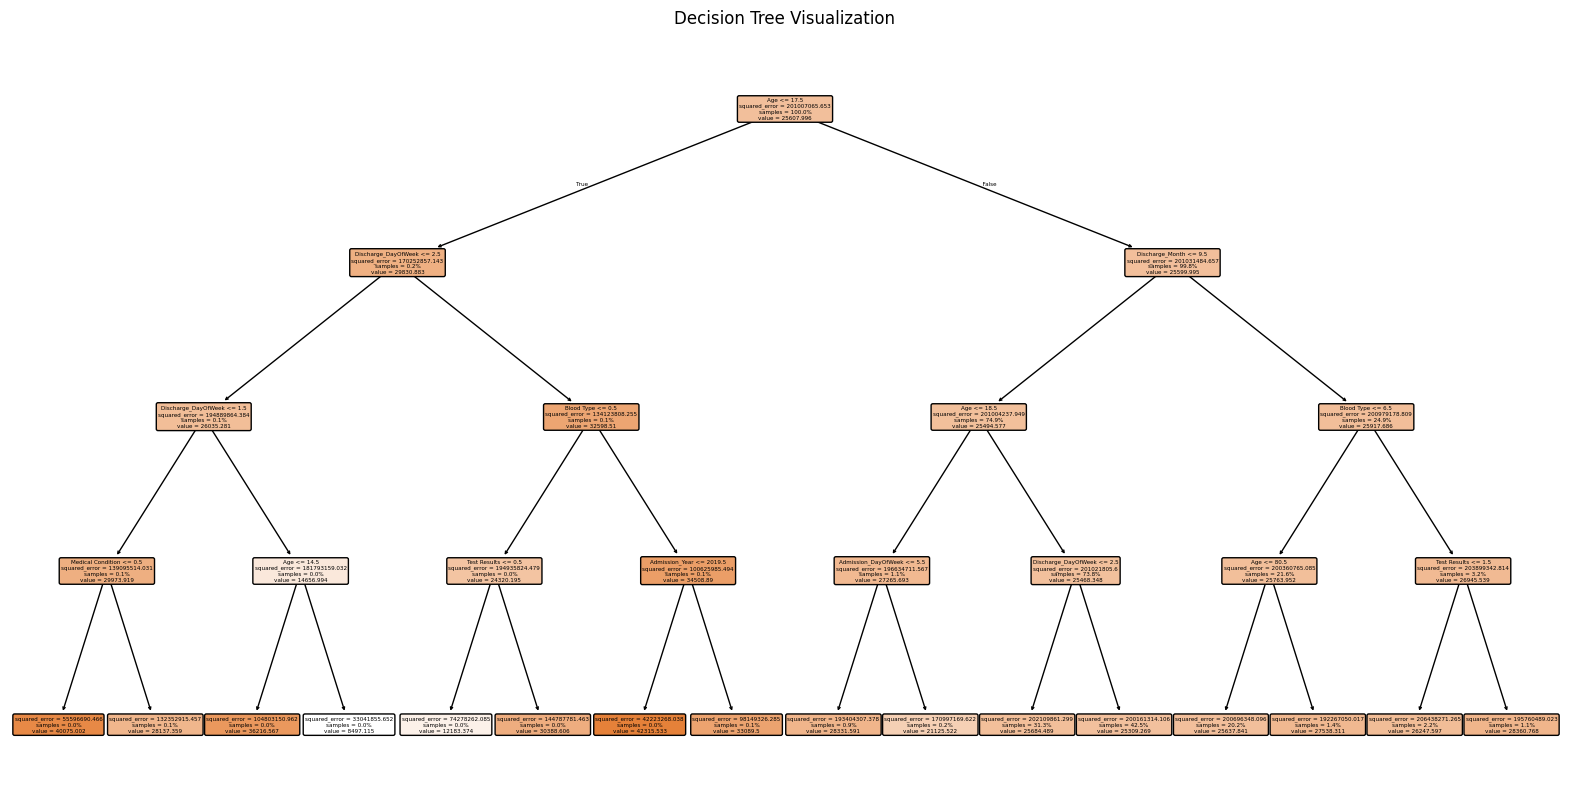

In [244]:
# Визуализируем наше дерево решений
visualize_decision_tree(decision_tree, feature_names, class_names=None, max_depth=4)

### 6.4 Случайный лес

<string>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



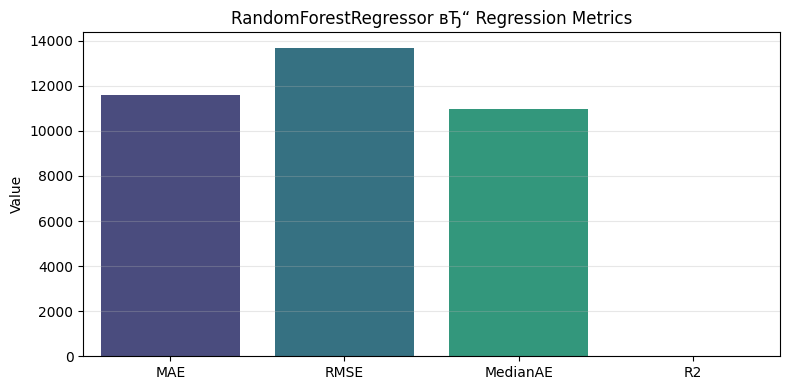


        RANDOMFORESTREGRESSOR REGRESSION EVALUATION         
  Metric      Value
     MAE 11614.9272
    RMSE 13690.0271
MedianAE 10990.3393
      R2     0.0663



In [245]:
# Train your model
random_forest = RandomForestRegressor(random_state=SEED)
random_forest.fit(X_train_preprocessed, y_train)

# Get predictions
y_pred = random_forest.predict(X_test_preprocessed)

# Evaluate
random_forest_metrics = evaluate_regression(
    y_true=y_test,
    y_pred=y_pred,
    model_name="RandomForestRegressor"
)

c:\Users\theea\Desktop\Healthcare\plots.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  category_counts = category_counts.sort_values(ascending=False)


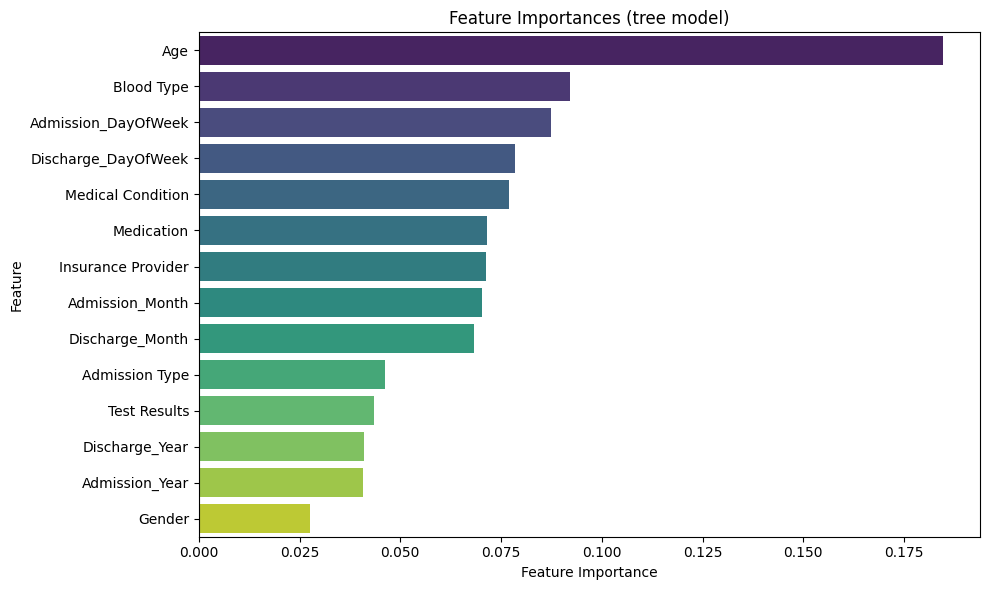

,Feature,Importance
7,Age,0.184599
1,Blood Type,0.092163
10,Admission_DayOfWeek,0.087477
13,Discharge_DayOfWeek,0.078489
2,Medical Condition,0.076854
5,Medication,0.071584
3,Insurance Provider,0.071347
9,Admission_Month,0.070224
12,Discharge_Month,0.068390
4,Admission Type,0.046088


In [246]:
plot_feature_importance(random_forest, feature_names)

Больше всего на сумму счёта влияет возраст пациента. На втором месте — месяц и день недели поступления. В какие-то месяцы и дни лечить в среднем дороже, в какие-то дешевле. Группа крови, диагноз, страховая, год поступления тоже имеют влияние, но уже заметно слабее. Тип поступления и пол почти не играют роли.

### 6.5 Градиентный бустинг

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 164
[LightGBM] [Info] Number of data points in the train set: 43888, number of used features: 14
[LightGBM] [Info] Start training from score 25607.996102


<string>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



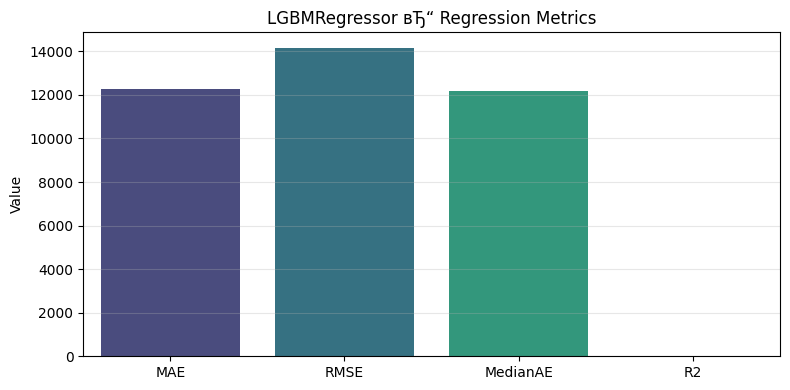


            LGBMREGRESSOR REGRESSION EVALUATION             
  Metric      Value
     MAE 12249.1860
    RMSE 14165.4198
MedianAE 12197.6123
      R2     0.0003



In [247]:
# Train your model
lgbm = LGBMRegressor(random_state=SEED)
lgbm.fit(X_train_preprocessed, y_train)

# Get predictions
y_pred = lgbm.predict(X_test_preprocessed)

# Evaluate
lgbm_metrics = evaluate_regression(
    y_true=y_test,
    y_pred=y_pred,
    model_name="LGBMRegressor"
)

c:\Users\theea\Desktop\Healthcare\plots.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  category_counts = category_counts.sort_values(ascending=False)


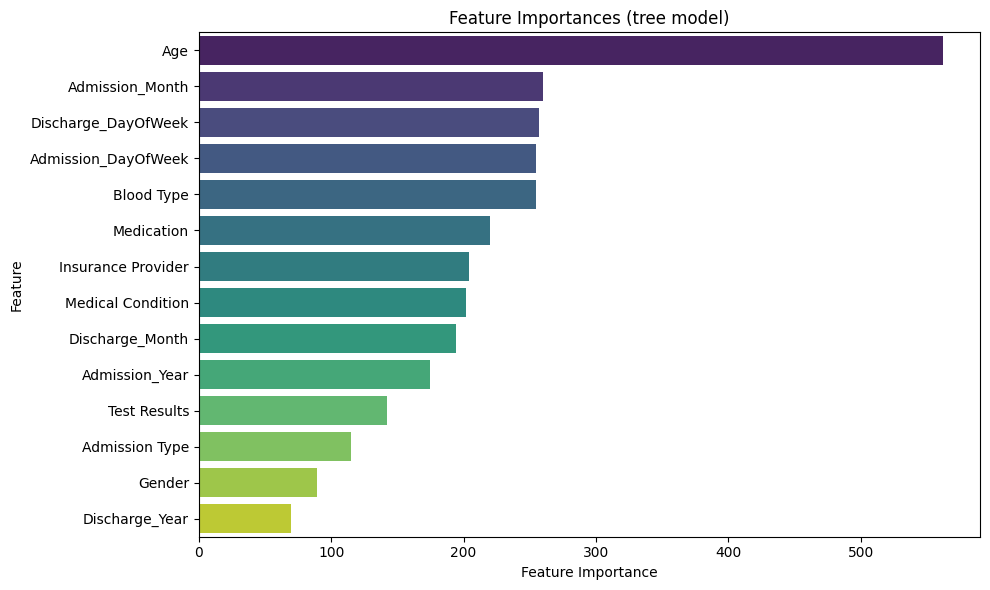

,Feature,Importance
7,Age,562
9,Admission_Month,260
13,Discharge_DayOfWeek,257
10,Admission_DayOfWeek,255
1,Blood Type,255
5,Medication,220
3,Insurance Provider,204
2,Medical Condition,202
12,Discharge_Month,194
8,Admission_Year,175


In [248]:
plot_feature_importance(lgbm, feature_names)

картина почти такая же, как у леса. сумма счёта в первую очередь зависит от возраста и календарных характеристик госпитализации, а пол и тип поступления играют минимальную роль.

### 6.6 Финальное сравнение метрик

In [249]:
final_metrics = {
    'dummy_regression': dummy_reg_metrics,
    'lin_reg': lin_reg_metrics,
    'decision_tree': decision_tree_metrics,
    'random_forest': random_forest_metrics,
    'lgbm': lgbm_metrics
}

result = pd.DataFrame(final_metrics.values(), index=final_metrics.keys())

In [250]:
result

,MAE,MSE,RMSE,MedianAE,R2
dummy_regression,12266.539361,2.007303e+08,14167.933750,12304.151162,-0.000022
lin_reg,12266.142524,2.007306e+08,14167.943800,12292.225781,-0.000024
decision_tree,12272.135874,2.011732e+08,14183.553994,12275.273056,-0.002229
random_forest,11614.927173,1.874168e+08,13690.027122,10990.339310,0.066305
lgbm,12249.185999,2.006591e+08,14165.419772,12197.612296,0.000333


<Axes: >

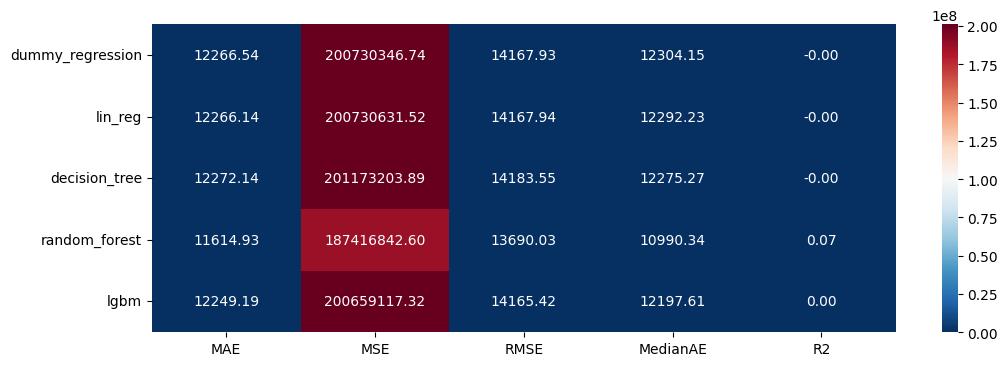

In [251]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.heatmap(result, cmap='RdBu_r', annot=True, fmt=".2f", ax=ax)

На базовом этапе ни линейная регрессия, ни дерево, ни LGBM практически не лучше константной модели: MAE и RMSE почти совпадают с DummyRegressor, коэффициент детерминации R² близок к нулю. Небольшое улучшение показывает только RandomForest.

In [252]:
result['R2']

dummy_regression   -0.000022
lin_reg            -0.000024
decision_tree      -0.002229
random_forest       0.066305
lgbm                0.000333
Name: R2, dtype: float64